In this notebook we try and implement the error correction.

In [1]:
import cv2 as cv 
import numpy as np

from flytracker.components import Frame, BlobDetector
from flytracker.utils import run_localization, FourArenasQRCodeMask, run_tracker

import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

# Getting a frame with an issue

In [2]:
%%time
coordinates = run_localization(200)

CPU times: user 3.25 s, sys: 344 ms, total: 3.59 s
Wall time: 1.78 s


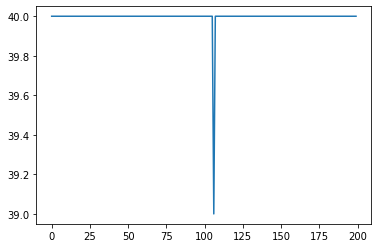

In [8]:
n_detected_flies = np.array([fly_coordinates.shape[0] for fly_coordinates in coordinates])
plt.plot(n_detected_flies)

In [10]:
np.where(n_detected_flies != 40)[0]

array([106])

So frame 106.

In [40]:
# For now we have to cycle through the first frames
path = '/Users/gert-janboth/Documents/flyTracker/data/movies/4arenas_QR.h264'
mask = FourArenasQRCodeMask().mask

capture = cv.VideoCapture(path)
localise_flies = BlobDetector()

for frame_idx in np.arange(200):
    frame = Frame(capture.read()[1], mask)
    location = localise_flies(frame)
    if location.shape[0] != 40:
        print(frame_idx)
        break

106


In [41]:
location.shape

(39, 2)

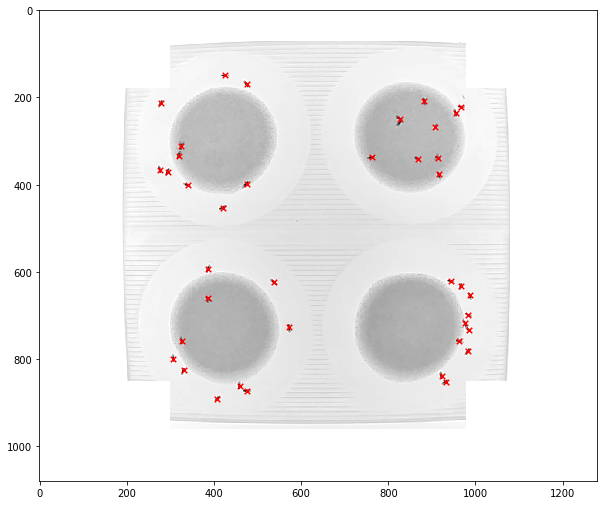

In [201]:
plt.figure(figsize=(10, 10))
plt.imshow(frame(), cmap='gray')
plt.scatter(location[:, 0], location[:, 1], s=30, c='red', marker='x')

So the issue is in the upper right arena.

# Error correction

The idea behind the error correction is that we do a contour finder, use k means to subdivide the contours until all old flies are fixed.

In [53]:
# We first need to threshold and apply some dilution
thresholded_frame = cv.threshold(frame(), 120, 255, cv.THRESH_BINARY_INV)[1]

kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
processed_frame = cv.dilate(thresholded_frame, kernel)
processed_frame = cv.medianBlur(processed_frame, 3)

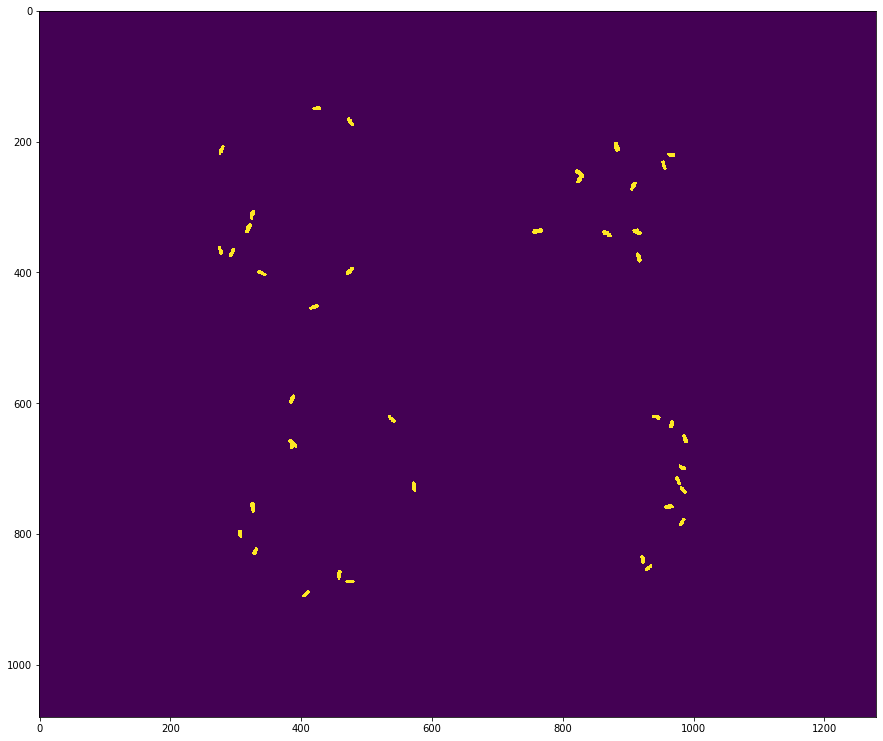

In [55]:
plt.figure(figsize=(15, 15))
plt.imshow(processed_frame)

Now what if we just kmeans this image?

In [66]:
thresholded_frame

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
pixels = cv.findNonZero(thresholded_frame).astype(np.float32)

In [79]:
n = 40
kmeans_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_RANDOM_CENTERS
ret, label, center = cv.kmeans(pixels, n, None, kmeans_criteria, 10, flags)

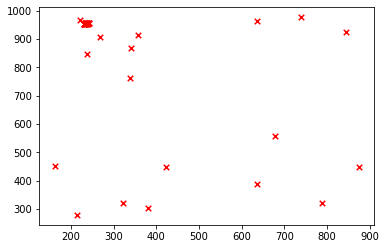

In [87]:
plt.scatter(center[:, 1], center[:, 0], s=30, c='red', marker='x')

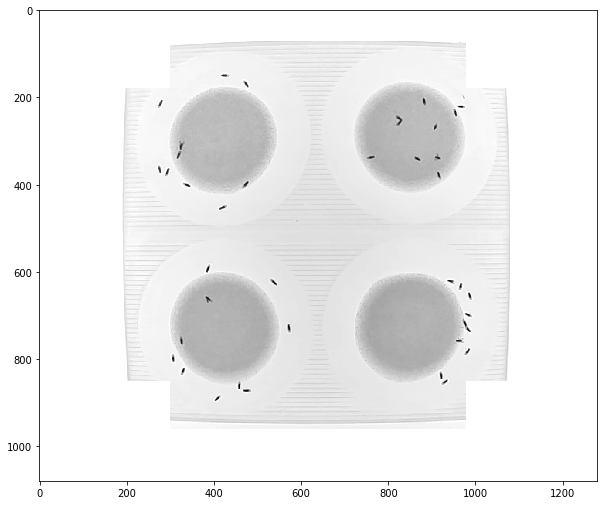

In [81]:
plt.figure(figsize=(10, 10))
plt.imshow(frame(), cmap='gray')
#plt.scatter(center[:, 0], center[:, 1], s=30, c='red', marker='x')

In [106]:
from sklearn.cluster import KMeans

In [102]:
fly_locs = np.stack(np.where(thresholded_frame != 0)).T[:, ::-1] # to get y and x good

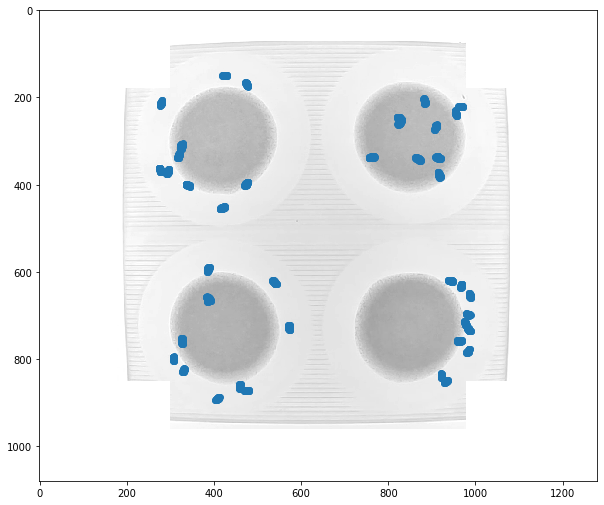

In [103]:
plt.figure(figsize=(10, 10))
plt.imshow(frame(), cmap='gray')

plt.scatter(fly_locs[:, 0], fly_locs[:, 1])

CPU times: user 1.23 s, sys: 59.4 ms, total: 1.29 s
Wall time: 204 ms


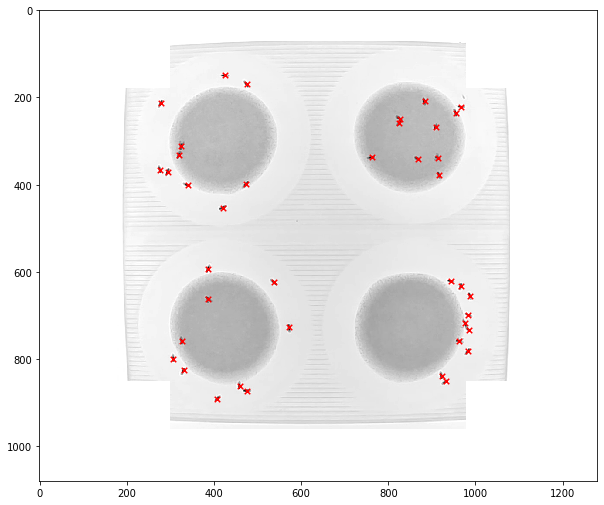

In [179]:
%%time
estim = KMeans(n_clusters=40)
estim.fit(fly_locs)

plt.figure(figsize=(10, 10))
plt.imshow(frame(), cmap='gray')
plt.scatter(estim.cluster_centers_[:, 0], estim.cluster_centers_[:, 1], s=30, c='red', marker='x')

In [178]:
estim.inertia_

31064.51765771893

In [ ]:
from sklearn.cluster import KMeans

class ErrorCorrect:
    def __init__(self, n_flies):
        self.n_flies = n_flies
        self.estimator = KMeans(n_clusters=self.n_flies)
        
    def __call__(self, image):
        # We first threshold
        thresholded_frame = cv.threshold(image(), 120, 255, cv.THRESH_BINARY_INV)[1]
        
        # Get the location of the non-zero pixels
        fly_pixels = np.stack(np.where(thresholded_frame != 0)).T[:, ::-1] # to get y and x good
        
        # Fit and get cluster centres
        estim.fit(fly_locs)
        locations = self.estimator.cluster_centers_
        
        return locations

# OPEN CV k means?

In [175]:
%%time
pixels = cv.findNonZero(thresholded_frame).astype(np.float32).squeeze()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 1000000000, 1e-8)
k = 40
dist_cv, labels, centers = cv.kmeans(pixels, k, None, criteria, 200, cv.KMEANS_RANDOM_CENTERS)

CPU times: user 1.35 s, sys: 102 ms, total: 1.45 s
Wall time: 360 ms


In [176]:
dist_cv

1311030.90166419

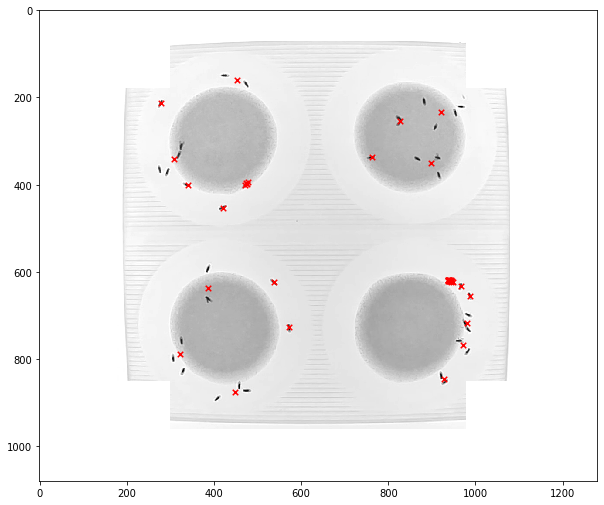

In [177]:
plt.figure(figsize=(10, 10))
plt.imshow(frame(), cmap='gray')
plt.scatter(centers[:, 0], centers[:, 1], s=30, c='red', marker='x')

# Testing

In [2]:
%%time
dataset = run_tracker(1000, n_flies=40)

CPU times: user 2min 41s, sys: 8.75 s, total: 2min 50s
Wall time: 28.6 s


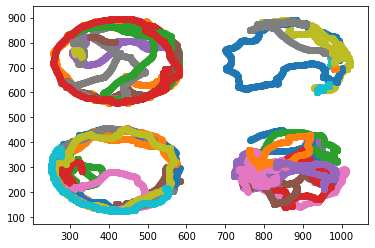

In [3]:
for fly in np.arange(40):
    plt.scatter(dataset[dataset[:, 1] == fly][:, 2], dataset[dataset[:, 1] == fly][:, 3])

NameError: name 'frame' is not defined

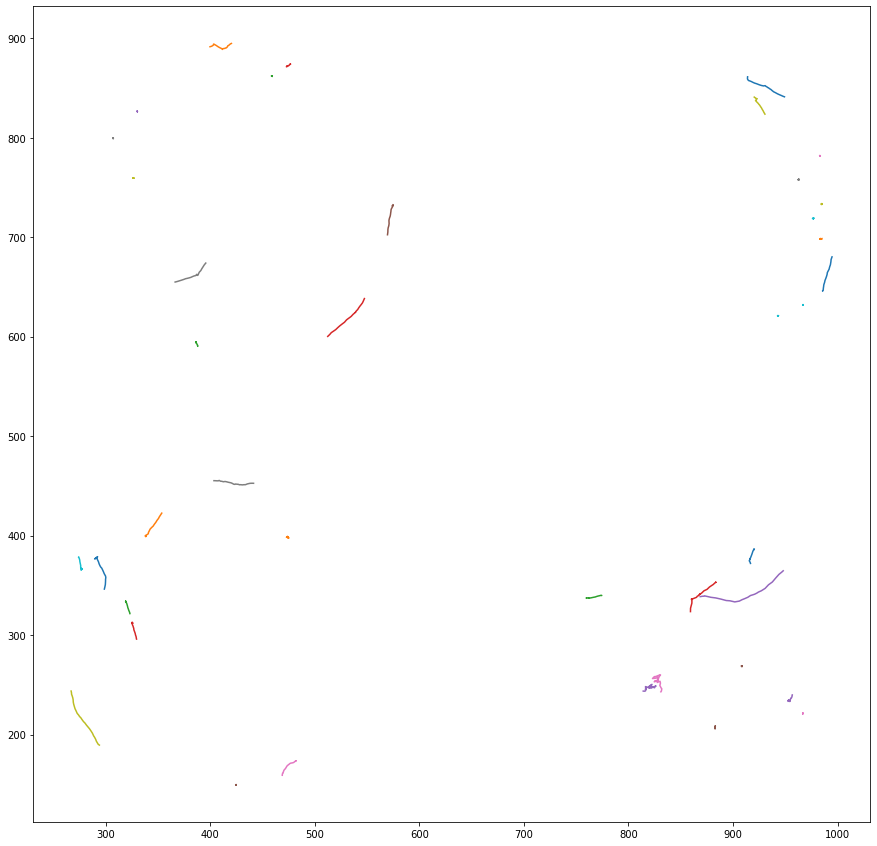

In [4]:
plt.figure(figsize=(15, 15))
for fly in np.arange(40):
    plt.plot(dataset[dataset[:, 1] == fly][90:120, 2], dataset[dataset[:, 1] == fly][90:120, 3])
plt.imshow(frame(), cmap='gray')
plt.ylim([500, 0])
plt.xlim([700, 1100])